## Keras -- MLPs on MNIST

In [1]:
# if you keras is not using tensorflow as backend set "KERAS_BACKEND=tensorflow" use this command

import warnings


from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns

from keras.initializers import RandomNormal
from keras.layers import Dropout
from keras.initializers import glorot_normal,glorot_uniform
import matplotlib.pyplot as plt

from keras.models import Sequential 
from keras.layers import Dense, Activation

from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,RMSprop,SGD

import numpy as np
import time

Using TensorFlow backend.


In [2]:

# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [3]:
# the data, shuffled and split between train and test sets 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d, %d)"%(X_train.shape[1], X_train.shape[2]))
print("Number of training examples :", X_test.shape[0], "and each image is of shape (%d, %d)"%(X_test.shape[1], X_test.shape[2]))

Number of training examples : 60000 and each image is of shape (28, 28)
Number of training examples : 10000 and each image is of shape (28, 28)


In [5]:
# if you observe the input shape its 3 dimensional vector
# for each image we have a (28*28) vector
# we will convert the (28*28) vector into single dimensional vector of 1 * 784 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]) 

In [6]:
# after converting the input images from 3d to 2d vectors

print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d)"%(X_train.shape[1]))
print("Number of training examples :", X_test.shape[0], "and each image is of shape (%d)"%(X_test.shape[1]))

Number of training examples : 60000 and each image is of shape (784)
Number of training examples : 10000 and each image is of shape (784)


In [7]:
# An example data point
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

In [8]:
# if we observe the above matrix each cell is having a value between 0-255
# before we move to apply machine learning algorithms lets try to normalize the data
# X => (X - Xmin)/(Xmax-Xmin) = X/255

X_train = X_train/255
X_test = X_test/255

In [9]:
# example data point after normlizing
print(X_train[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [10]:
# here we are having a class number for each image
print("Class label of first image :", y_train[0])

# lets convert this into a 10 dimensional vector
# ex: consider an image is 5 convert it into 5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
# this conversion needed for MLPs 

Y_train = np_utils.to_categorical(y_train, 10) 
Y_test = np_utils.to_categorical(y_test, 10)

print("After converting the output into a vector : ",Y_train[0])

Class label of first image : 5
After converting the output into a vector :  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


<h2>  Softmax classifier  </h2>

In [11]:
# https://keras.io/getting-started/sequential-model-guide/

# The Sequential model is a linear stack of layers.
# you can create a Sequential model by passing a list of layer instances to the constructor:

# model = Sequential([
#     Dense(32, input_shape=(784,)),
#     Activation('relu'),
#     Dense(10),
#     Activation('softmax'),
# ])

# You can also simply add layers via the .add() method:

# model = Sequential()
# model.add(Dense(32, input_dim=784))
# model.add(Activation('relu'))

###

# https://keras.io/layers/core/

# keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', 
# bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
# kernel_constraint=None, bias_constraint=None)

# Dense implements the operation: output = activation(dot(input, kernel) + bias) where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# output = activation(dot(input, kernel) + bias)  => y = activation(WT. X + b)

####

# https://keras.io/activations/

# Activations can either be used through an Activation layer, or through the activation argument supported by all forward layers:

# from keras.layers import Activation, Dense

# model.add(Dense(64))
# model.add(Activation('tanh'))

# This is equivalent to:
# model.add(Dense(64, activation='tanh'))

# there are many activation functions ar available ex: tanh, relu, softmax


In [12]:
# some model parameters

output_dim = 10
input_dim = X_train.shape[1]

batch_size = 128 
nb_epoch = 20

In [13]:
# start building a model
model = Sequential()

# The model needs to know what input shape it should expect. 
# For this reason, the first layer in a Sequential model 
# (and only the first, because following layers can do automatic shape inference)
# needs to receive information about its input shape. 
# you can use input_shape and input_dim to pass the shape of input

# output_dim represent the number of nodes need in that layer
# here we have 10 nodes

model.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
# Before training a model, you need to configure the learning process, which is done via the compile method

# It receives three arguments:
# An optimizer. This could be the string identifier of an existing optimizer , https://keras.io/optimizers/
# A loss function. This is the objective that the model will try to minimize., https://keras.io/losses/
# A list of metrics. For any classification problem you will want to set this to metrics=['accuracy'].  https://keras.io/metrics/


# Note: when using the categorical_crossentropy loss, your targets should be in categorical format 
# (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except 
# for a 1 at the index corresponding to the class of the sample).

# that is why we converted out labels into vectors

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Keras models are trained on Numpy arrays of input data and labels. 
# For training a model, you will typically use the  fit function

# fit(self, x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, 
# validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, 
# validation_steps=None)

# fit() function Trains the model for a fixed number of epochs (iterations on a dataset).

# it returns A History object. Its History.history attribute is a record of training loss values and 
# metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

# https://github.com/openai/baselines/issues/20

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test)) 


Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 46us/step - loss: 1.2635 - acc: 0.7025 - val_loss: 0.8063 - val_acc: 0.8313
Epoch 2/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.7149 - acc: 0.8392 - val_loss: 0.6055 - val_acc: 0.8628
Epoch 3/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.5873 - acc: 0.8592 - val_loss: 0.5248 - val_acc: 0.8735
Epoch 4/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.5259 - acc: 0.8688 - val_loss: 0.4794 - val_acc: 0.8823
Epoch 5/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.4884 - acc: 0.8750 - val_loss: 0.4500 - val_acc: 0.8872
Epoch 6/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.4626 - acc: 0.8795 - val_loss: 0.4285 - val_acc: 0.8912
Epoch 7/20
60000/60000 [==============================] - 2s 27us/step - loss: 0

Test score: 0.3358818498134613
Test accuracy: 0.9073


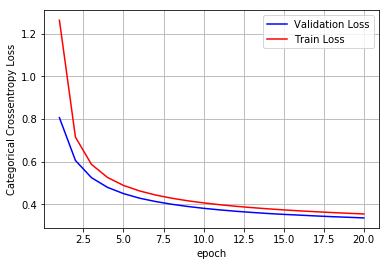

In [15]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

 <h3>  MLP + Sigmoid activation + SGDOptimizer </h3>

In [16]:
# Multilayer perceptron

model_sigmoid = Sequential()
model_sigmoid.add(Dense(512, activation='sigmoid', input_shape=(input_dim,)))
# now the model will take as input arrays of shape (batch size, 784)
model_sigmoid.add(Dense(128, activation='sigmoid'))
model_sigmoid.add(Dense(output_dim, activation='softmax'))
# and output arrays of shape (batch size, 10)

model_sigmoid.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_sigmoid.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_sigmoid.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 34us/step - loss: 2.2611 - acc: 0.2426 - val_loss: 2.2139 - val_acc: 0.4088
Epoch 2/20
60000/60000 [==============================] - 2s 31us/step - loss: 2.1695 - acc: 0.4865 - val_loss: 2.1115 - val_acc: 0.5417
Epoch 3/20
60000/60000 [==============================] - 2s 30us/step - loss: 2.0502 - acc: 0.5919 - val_loss: 1.9650 - val_acc: 0.6392
Epoch 4/20
60000/60000 [==============================] - 2s 30us/step - loss: 1.8799 - acc: 0.6397 - val_loss: 1.7625 - val_acc: 0.6488
Epoch 5/20
60000/60000 [==============================] - 2s 31us/step - loss: 1.6598 - acc: 0.6719 - val_loss: 1.5243 - val_acc: 0.7013
Epoch 6/20
60000/60000 [==============================] - 2s 31us/step - loss: 1.4274 - acc: 0.7061 - val_loss: 1.2996 - val_acc: 0.7266
Epoch 7/20
60000/60000 [==============================] - 2s 30us/step - loss: 1.2243 - acc: 0.7387 - val_loss: 1.1185 - val_acc

Test score: 0.46792866106033326
Test accuracy: 0.8772


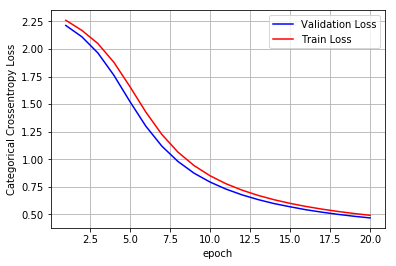

In [18]:
score = model_sigmoid.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


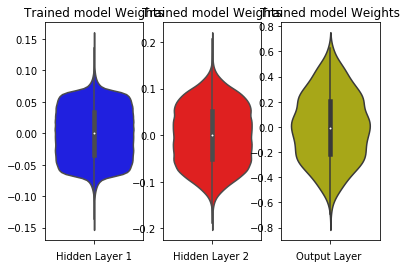

In [19]:
w_after = model_sigmoid.get_weights()
#w_after[1 & 3] are the output arrays of hidden layer 1 and 2
h1_w = w_after[0].flatten().reshape(-1,1) #-1 means numpy will figure this by looking at the 'length of the array and remaining dimensions' 
h2_w = w_after[2].flatten().reshape(-1,1)
out_w = w_after[4].flatten().reshape(-1,1)


fig = plt.figure()
plt.title("Weight matrices after model trained")
plt.subplot(1, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h2>MLP + Sigmoid activation + ADAM </h2>

In [20]:
model_sigmoid = Sequential()
model_sigmoid.add(Dense(512, activation='sigmoid', input_shape=(input_dim,)))
model_sigmoid.add(Dense(128, activation='sigmoid'))
model_sigmoid.add(Dense(output_dim, activation='softmax'))

model_sigmoid.summary()

model_sigmoid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_sigmoid.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 42us/step - loss: 0.5273 - acc: 0.8641 - val_loss: 0.2507 - val_acc: 0.9282
Epoch 2/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.2184 - acc: 0.9365 - val_loss: 0.1874 - val_acc: 0.9438
Epoch 3/20
60000/60000 [==============================] - 2s 36us/step - los

Test score: 0.0850668552498435
Test accuracy: 0.9791


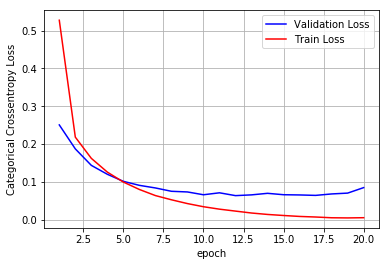

In [21]:
score = model_sigmoid.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


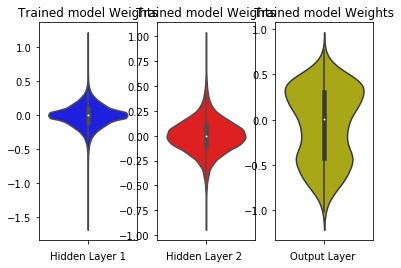

In [22]:
w_after = model_sigmoid.get_weights()
#w_after[1 & 3] are the output arrays of hidden layer 1 and 2
h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[2].flatten().reshape(-1,1)
out_w = w_after[4].flatten().reshape(-1,1)


fig = plt.figure()
plt.title("Weight matrices after model trained")
plt.subplot(1, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h2> MLP + ReLU +SGD </h2>

In [23]:
# Multilayer perceptron

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# for relu layers
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
# h1 =>  σ=√(2/(fan_in) = 0.062  => N(0,σ) = N(0,0.062)
# h2 =>  σ=√(2/(fan_in) = 0.125  => N(0,σ) = N(0,0.125)
# out =>  σ=√(2/(fan_in+1) = 0.120  => N(0,σ) = N(0,0.120)

model_relu = Sequential()
model_relu.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.062, seed=None)))
model_relu.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.125, seed=None)) )
model_relu.add(Dense(output_dim, activation='softmax'))

model_relu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_relu.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_relu.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.7488 - acc: 0.7877 - val_loss: 0.3881 - val_acc: 0.8896
Epoch 2/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.3525 - acc: 0.8992 - val_loss: 0.2996 - val_acc: 0.9137
Epoch 3/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.2899 - acc: 0.9163 - val_loss: 0.2617 - val_acc: 0.9248
Epoch 4/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.2552 - acc: 0.9264 - val_loss: 0.2376 - val_acc: 0.9323
Epoch 5/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.2310 - acc: 0.9341 - val_loss: 0.2179 - val_acc: 0.9377
Epoch 6/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.2124 - acc: 0.9391 - val_loss: 0.2021 - val_acc: 0.9424
Epoch 7/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.1975 - acc: 0.9438 - val_loss: 0.1920 - val_acc

Test score: 0.12241002663522958
Test accuracy: 0.9642


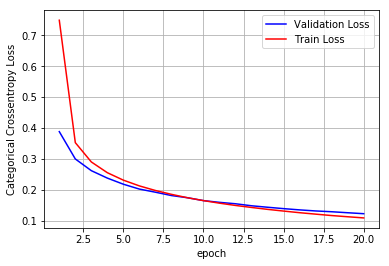

In [25]:
score = model_relu.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


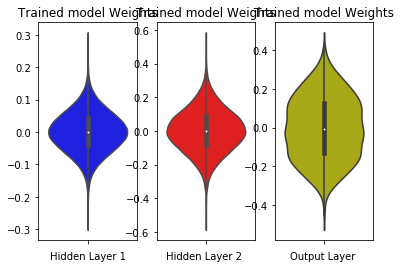

In [26]:
w_after = model_relu.get_weights()
#w_after[1 & 3] are the output arrays of hidden layer 1 and 2
h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[2].flatten().reshape(-1,1)
out_w = w_after[4].flatten().reshape(-1,1)


fig = plt.figure()
plt.title("Weight matrices after model trained")
plt.subplot(1, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h2> MLP + ReLU + ADAM </h2>

In [27]:
model_relu = Sequential()
model_relu.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.062, seed=None)))
model_relu.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.125, seed=None)) )
model_relu.add(Dense(output_dim, activation='softmax'))

print(model_relu.summary())

model_relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_relu.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 42us/step - loss: 0.2211 - acc: 0.9336 - val_loss: 0.1209 - val_acc: 0.9605
Epoch 2/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.0826 - acc: 0.9749 - val_loss: 0.0822 - val_acc: 0.9748
Epoch 3/20
60000/60000 [==============================] - 2s 36us/step 

Test score: 0.088074071524906
Test accuracy: 0.9828


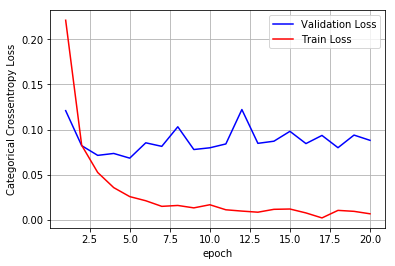

In [28]:
score = model_relu.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


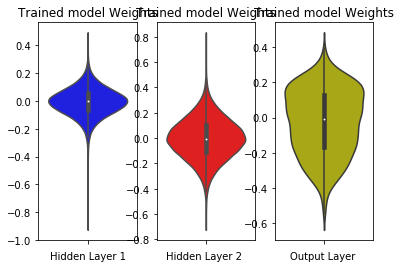

In [29]:
w_after = model_relu.get_weights()
#w_after[1 & 3] are the output arrays of hidden layer 1 and 2
h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[2].flatten().reshape(-1,1)
out_w = w_after[4].flatten().reshape(-1,1)


fig = plt.figure()
plt.title("Weight matrices after model trained")
plt.subplot(1, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h2> MLP + Batch-Norm on hidden Layers + AdamOptimizer </2>

In [30]:
# Multilayer perceptron

# https://intoli.com/blog/neural-network-initialization/ 
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(ni+ni+1) = 0.039  => N(0,σ) = N(0,0.039)
# h2 =>  σ=√(2/(ni+ni+1) = 0.055  => N(0,σ) = N(0,0.055)
# h1 =>  σ=√(2/(ni+ni+1) = 0.120  => N(0,σ) = N(0,0.120)


model_batch = Sequential()

model_batch.add(Dense(512, activation='sigmoid', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_batch.add(BatchNormalization())

model_batch.add(Dense(128, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_batch.add(BatchNormalization())

model_batch.add(Dense(output_dim, activation='softmax'))


model_batch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 471,434
Trainable params: 470,154
Non-trainable params: 1,280
_________________________________________________________________


In [31]:
model_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_batch.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 76us/step - loss: 0.2991 - acc: 0.9102 - val_loss: 0.2142 - val_acc: 0.9369
Epoch 2/20
60000/60000 [==============================] - 4s 62us/step - loss: 0.1740 - acc: 0.9487 - val_loss: 0.1710 - val_acc: 0.9508
Epoch 3/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.1368 - acc: 0.9586 - val_loss: 0.1423 - val_acc: 0.9568
Epoch 4/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.1131 - acc: 0.9660 - val_loss: 0.1321 - val_acc: 0.9593
Epoch 5/20
60000/60000 [==============================] - 4s 58us/step - loss: 0.0958 - acc: 0.9720 - val_loss: 0.1242 - val_acc: 0.9613
Epoch 6/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.0817 - acc: 0.9753 - val_loss: 0.1081 - val_acc: 0.9676
Epoch 7/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.0695 - acc: 0.9787 - val_loss: 0.1087 - val_acc

Test score: 0.09471559054116951
Test accuracy: 0.9748


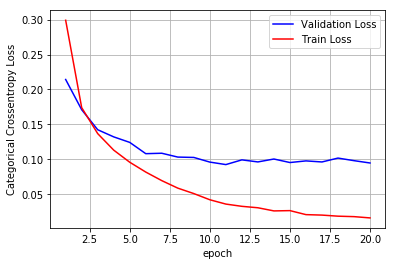

In [32]:
score = model_batch.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


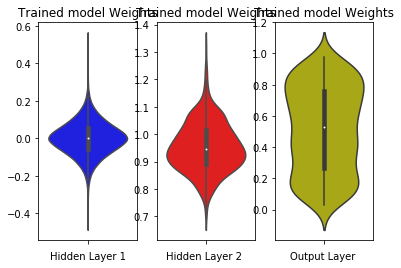

In [33]:
w_after = model_batch.get_weights()
#w_after[1 & 3] are the output arrays of hidden layer 1 and 2
h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[2].flatten().reshape(-1,1)
out_w = w_after[4].flatten().reshape(-1,1)


fig = plt.figure()
plt.title("Weight matrices after model trained")
plt.subplot(1, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h2> 5. MLP + Dropout + AdamOptimizer </h2>

In [34]:
# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

from keras.layers import Dropout

model_drop = Sequential()

model_drop.add(Dense(512, activation='sigmoid', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(128, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(output_dim, activation='softmax'))


model_drop.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
___________________________

In [35]:
model_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.6628 - acc: 0.7957 - val_loss: 0.2829 - val_acc: 0.9173
Epoch 2/20
60000/60000 [==============================] - 4s 62us/step - loss: 0.4272 - acc: 0.8694 - val_loss: 0.2494 - val_acc: 0.9276
Epoch 3/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.3811 - acc: 0.8825 - val_loss: 0.2318 - val_acc: 0.9305
Epoch 4/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.3547 - acc: 0.8920 - val_loss: 0.2129 - val_acc: 0.9360
Epoch 5/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.3294 - acc: 0.8995 - val_loss: 0.2126 - val_acc: 0.9368
Epoch 6/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.3178 - acc: 0.9027 - val_loss: 0.1963 - val_acc: 0.9414
Epoch 7/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.3008 - acc: 0.9091 - val_loss: 0.1929 - val_acc

Test score: 0.11099725784473122
Test accuracy: 0.9677


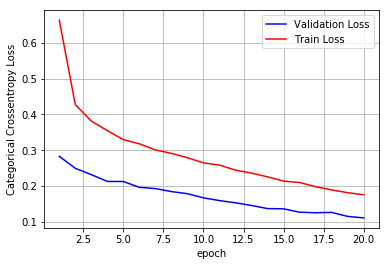

In [36]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


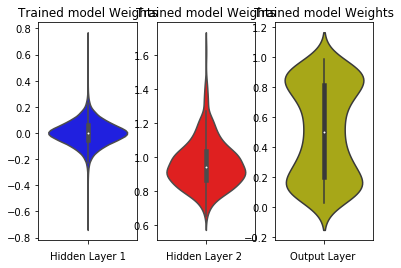

In [37]:
w_after = model_drop.get_weights()
#w_after[1 & 3] are the output arrays of hidden layer 1 and 2
h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[2].flatten().reshape(-1,1)
out_w = w_after[4].flatten().reshape(-1,1)


fig = plt.figure()
plt.title("Weight matrices after model trained")
plt.subplot(1, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h2> Hyper-parameter tuning of Keras models using Sklearn </h2>

In [38]:
def best_hyperparameters(activ):

    model = Sequential()
    model.add(Dense(512, activation=activ, input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.062, seed=None)))
    model.add(Dense(128, activation=activ, kernel_initializer=RandomNormal(mean=0.0, stddev=0.125, seed=None)) )
    model.add(Dense(output_dim, activation='softmax'))


    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

In [39]:
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

activ = ['sigmoid','relu']

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=best_hyperparameters, epochs=nb_epoch, batch_size=batch_size, verbose=0)
param_grid = dict(activ=activ)

# if you are using CPU
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# if you are using GPU dont use the n_jobs parameter

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, Y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [40]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.975617 using {'activ': 'relu'}
0.975400 (0.001349) with: {'activ': 'sigmoid'}
0.975617 (0.002073) with: {'activ': 'relu'}


## Model 1

In [110]:
from keras.layers import Dropout

model_1 = Sequential()

model_1.add(Dense(784, activation='sigmoid', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))

model_1.add(Dense(128, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))

model_1.add(Dense(output_dim, activation='softmax'))


model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 784)               615440    
_________________________________________________________________
batch_normalization_44 (Batc (None, 784)               3136      
_________________________________________________________________
dropout_34 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 128)               100480    
_________________________________________________________________
batch_normalization_45 (Batc (None, 128)               512       
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 10)                1290      
Total para

In [111]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_1.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=0, validation_data=(X_test, Y_test))

In [112]:
def plotCurve(model):
    score = model.evaluate(X_test, Y_test, verbose=0) 
    print('Test score:', score[0]) 
    print('Test accuracy:', score[1])

    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

    # list of epoch numbers
    x = list(range(1,nb_epoch+1))

    vy = history.history['val_loss']
    ty = history.history['loss']
    plt_dynamic(x, vy, ty, ax)

In [113]:
def plotWeights(model):
    %matplotlib notebook
    w_after = model.get_weights()
    #w_after[1 & 3] are the output arrays of hidden layer 1 and 2
    h1_w = w_after[0].flatten().reshape(-1,1)
    h2_w = w_after[2].flatten().reshape(-1,1)
    out_w = w_after[4].flatten().reshape(-1,1)


    fig = plt.figure()
    plt.title("Weight matrices after model trained")
    plt.subplot(1, 3, 1)
    plt.title("Trained model Weights")
    ax = sns.violinplot(y=h1_w,color='b')
    plt.xlabel('Hidden Layer 1')

    plt.subplot(1, 3, 2)
    plt.title("Trained model Weights")
    ax = sns.violinplot(y=h2_w, color='r')
    plt.xlabel('Hidden Layer 2 ')

    plt.subplot(1, 3, 3)
    plt.title("Trained model Weights")
    ax = sns.violinplot(y=out_w,color='y')
    plt.xlabel('Output Layer ')
    plt.show()

Test score: 0.1096681955449283
Test accuracy: 0.9673


<IPython.core.display.Javascript object>


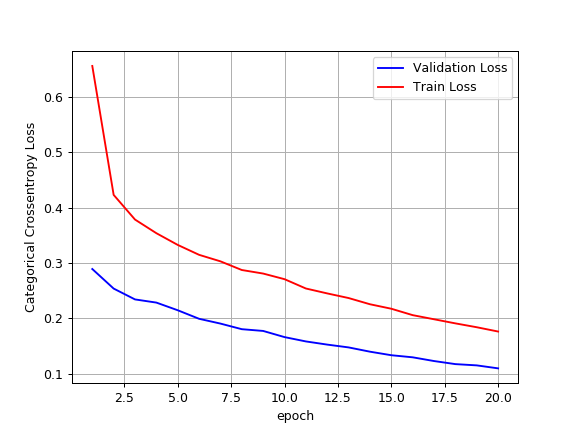

In [114]:
plotCurve(model_1)

<IPython.core.display.Javascript object>


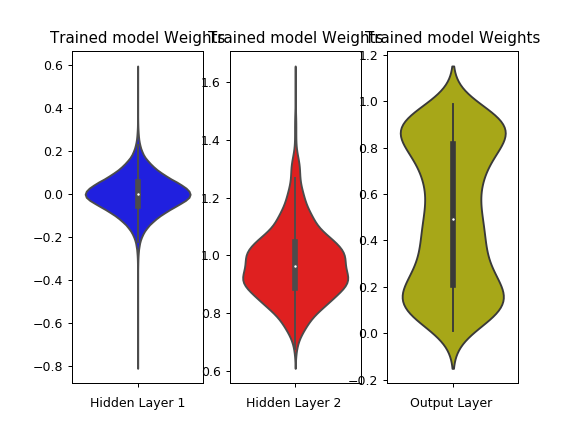

In [115]:
plotWeights(model_1)

## Model 2

In [116]:
model_2 = Sequential()

model_2.add(Dense(784, activation='relu', input_shape=(input_dim,), kernel_initializer=glorot_uniform()))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))

model_2.add(Dense(512, activation='relu', kernel_initializer=glorot_uniform()) )
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))

model_2.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform()) )
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))

model_2.add(Dense(output_dim, activation='softmax'))


model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 784)               615440    
_________________________________________________________________
batch_normalization_46 (Batc (None, 784)               3136      
_________________________________________________________________
dropout_36 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 512)               401920    
_________________________________________________________________
batch_normalization_47 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 128)               65664     
__________

In [117]:
warnings.filterwarnings("ignore")
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_2.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=0, validation_data=(X_test, Y_test))

score = model_2.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.05726615263057174
Test accuracy: 0.9847


Test score: 0.05726615263057174
Test accuracy: 0.9847


<IPython.core.display.Javascript object>


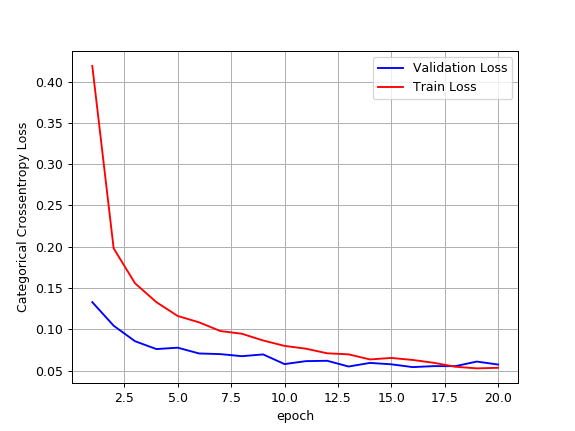

In [118]:
plotCurve(model_2)


<IPython.core.display.Javascript object>


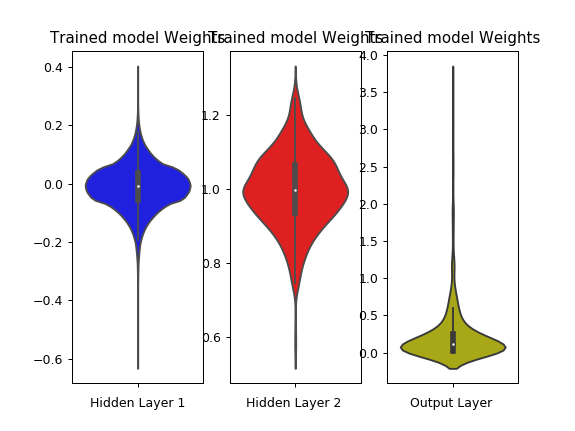

In [119]:
plotWeights(model_2)

## Model 3

In [120]:
model_3 = Sequential()

model_3.add(Dense(100, activation='relu', input_shape=(input_dim,), kernel_initializer=glorot_uniform()))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense(100, activation='relu', kernel_initializer=glorot_uniform()) )
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense(100, activation='relu', kernel_initializer=glorot_uniform()) )
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense(100, activation='relu', kernel_initializer=glorot_uniform()) )
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense(output_dim, activation='softmax'))


model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 100)               78500     
_________________________________________________________________
batch_normalization_49 (Batc (None, 100)               400       
_________________________________________________________________
dropout_39 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_50 (Batc (None, 100)               400       
_________________________________________________________________
dropout_40 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 100)               10100     
__________

In [121]:
warnings.filterwarnings("ignore")
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_3.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=0, validation_data=(X_test, Y_test))

score = model_3.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.07269749533357099
Test accuracy: 0.9792


Test score: 0.07269749533357099
Test accuracy: 0.9792


<IPython.core.display.Javascript object>


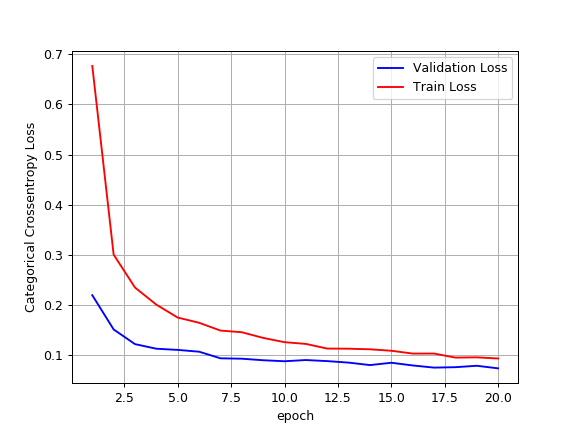

In [122]:
plotCurve(model_3)

<IPython.core.display.Javascript object>


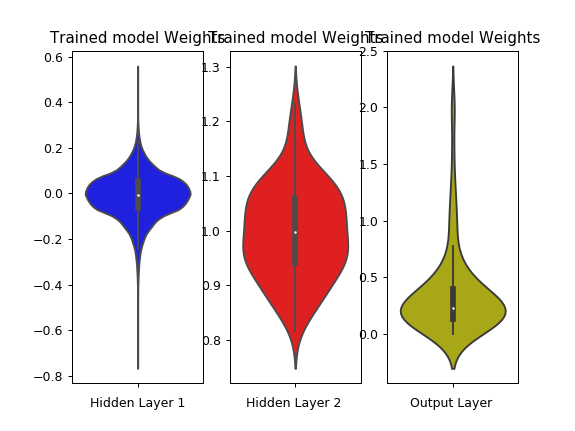

In [123]:
plotWeights(model_3)

In [106]:
model_4 = Sequential()

model_4.add(Dense(100, activation='relu', input_shape=(input_dim,), kernel_initializer=glorot_uniform()))
#model_4.add(BatchNormalization())
#model_4.add(Dropout(0.3))

model_4.add(Dense(100, activation='relu', kernel_initializer=glorot_uniform()) )
#model_4.add(BatchNormalization())
#model_4.add(Dropout(0.3))

model_4.add(Dense(100, activation='relu', kernel_initializer=glorot_uniform()) )
#model_4.add(BatchNormalization())
#model_4.add(Dropout(0.3))

model_4.add(Dense(100, activation='relu', kernel_initializer=glorot_uniform()) )
#model_4.add(BatchNormalization())
#model_4.add(Dropout(0.3))

model_4.add(Dense(output_dim, activation='softmax'))


model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_101 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_102 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_103 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_104 (Dense)            (None, 10)                1010      
Total params: 109,810
Trainable params: 109,810
Non-trainable params: 0
_________________________________________________________________


In [124]:
warnings.filterwarnings("ignore")
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_4.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=0, validation_data=(X_test, Y_test))

score = model_4.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.1159774422180177
Test accuracy: 0.9791


Test score: 0.1159774422180177
Test accuracy: 0.9791


<IPython.core.display.Javascript object>


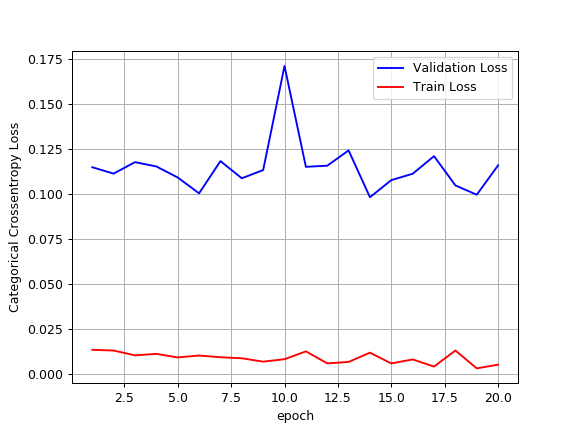

In [125]:
plotCurve(model_4)

<IPython.core.display.Javascript object>


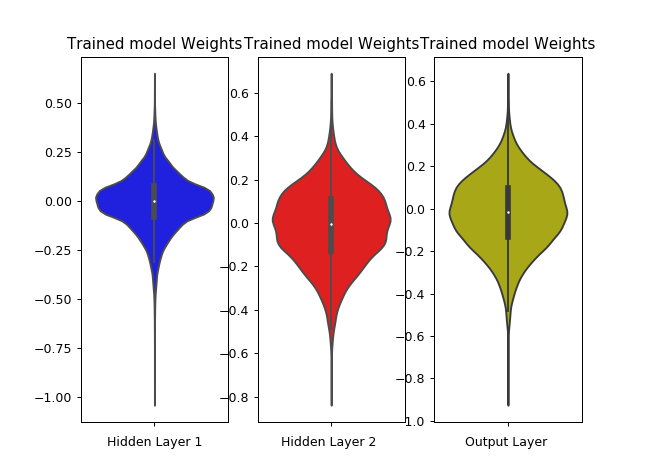

In [126]:
plotWeights(model_4)

In [127]:
from prettytable import PrettyTable

pt = PrettyTable()
print("For model 2")
pt.field_names = ["Layer 1 Activation + Kernel","Layer 2 Activation + Kernel"," Layer 3 Activation + Kernel", "Test Score", "Test Accuracy"]

pt.add_row(["Sigmoid + Random normal", "Sigmoid + Random Normal", "Sigmoid + Random Normal", 0.1712, 0.9516])
pt.add_row(["Sigmoid + Glorot Uniform", "Sigmoid + Random Normal", "Sigmoid + Random Normal", 0.1608, 0.9548])
pt.add_row(["Sigmoid + Random normal", "Sigmoid + Glorot Uniform", "Sigmoid + Random Normal", 0.0914, 0.9743])
pt.add_row(["Sigmoid + Random normal", "Sigmoid + Random Normal", "Sigmoid + Glorot Uniform", 0.1050, 0.969])
pt.add_row(["", "", "", "", "" ])

pt.add_row(["ReLu + Glorot Uniform", "Sigmoid + Glorot Uniform", "Sigmoid + Glorot Uniform", 0.0593, 0.9837])
pt.add_row(["Sigmoid + Glorot Uniform", "ReLu + Glorot Uniform", "Sigmoid + Glorot Uniform", 0.0508, 0.984])
pt.add_row(["Sigmoid + Glorot Uniform", "Sigmoid + Glorot Uniform", "ReLu + Glorot Uniform", 0.0645, 0.9805])
pt.add_row(["ReLu + Glorot Uniform", "ReLu + Glorot Uniform", "ReLu + Glorot Uniform", 0.0565, 0.984])


print(pt)

For model 2
+-----------------------------+-----------------------------+------------------------------+------------+---------------+
| Layer 1 Activation + Kernel | Layer 2 Activation + Kernel |  Layer 3 Activation + Kernel | Test Score | Test Accuracy |
+-----------------------------+-----------------------------+------------------------------+------------+---------------+
|   Sigmoid + Random normal   |   Sigmoid + Random Normal   |   Sigmoid + Random Normal    |   0.1712   |     0.9516    |
|   Sigmoid + Glorot Uniform  |   Sigmoid + Random Normal   |   Sigmoid + Random Normal    |   0.1608   |     0.9548    |
|   Sigmoid + Random normal   |   Sigmoid + Glorot Uniform  |   Sigmoid + Random Normal    |   0.0914   |     0.9743    |
|   Sigmoid + Random normal   |   Sigmoid + Random Normal   |   Sigmoid + Glorot Uniform   |   0.105    |     0.969     |
|                             |                             |                              |            |               |
|    ReLu + 

In [130]:
from prettytable import PrettyTable

pt = PrettyTable()

pt.field_names = ["Model Name","Number Of Layers","Architecture", "Test Score", "Test Accuracy"]

pt.add_row(["Model 1", 2 , "784-128", 0.1096, 0.9673])
pt.add_row(["Model 2",3 , "784-512-128", 0.0572, 0.9847])
pt.add_row(["Model 3",4 , "100-100-100-100", 0.0726, 0.9792])
pt.add_row(["" , "" , "(with BN, with Dropouts)", "", "" ])
pt.add_row(["Model 4",4 , "100-100-100-100", 0.1159, 0.9791])
pt.add_row(["" , "" , "(No BN, No Dropouts)", "", "" ])

print(pt)

+------------+------------------+--------------------------+------------+---------------+
| Model Name | Number Of Layers |       Architecture       | Test Score | Test Accuracy |
+------------+------------------+--------------------------+------------+---------------+
|  Model 1   |        2         |         784-128          |   0.1096   |     0.9673    |
|  Model 2   |        3         |       784-512-128        |   0.0572   |     0.9847    |
|  Model 3   |        4         |     100-100-100-100      |   0.0726   |     0.9792    |
|            |                  | (with BN, with Dropouts) |            |               |
|  Model 4   |        4         |     100-100-100-100      |   0.1159   |     0.9791    |
|            |                  |   (No BN, No Dropouts)   |            |               |
+------------+------------------+--------------------------+------------+---------------+


# Conclusion

1) The test score and accuracy score is almost same in model 1 as obtained in previous model, though we increased the number of activation units in the first layer.

2) The accuracy score and the test score has improved by using glorot uniform initializaion of kernels instead of randomly intializing the kernels.

3) The accuracy score and the test score improved significantly on using *ReLu* as activation function instead of *Sigmoid*.

4) It can be said Model 2 is neither overfitted nor it is underfitted by looking at the Validation loss vs Train loss curve.

5) Model 3 and Model 4 has achieved a very similar accuracy but there is a significant difference in the test score, though they are same number of layers and activation units and the diffrence is use of batch normalization and dropouts after avery layer.

6) It can also be concluded that Model 3 is neither overfitting nor it is underfitting while Model 4 is clearly overfitted model, looking at the Validation loss vs Train loss curve. Again, the difference being batch normalization and dropouts after avery layer